# Исследование объявлений о продаже квартир

В нашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Наша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

## Загрузим файл с данными и посмотрим общую информацию. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#pd.set_option('display.max_rows', None) #отображаем все строки
#pd.set_option('display.max_columns', None)

In [2]:
data = pd.read_csv('datasets/real_estate_data.csv', sep='\t', decimal='.')
data.head() #видно, что разделителем является \t, поэтому отредактируем запрос .read_csv

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

Заметим, что не по всем столбцам данные заполнены полностью. Есть пропуски и нулевые значения, которые при необходимости нужно будет устранить/заполнить. В некоторых случаях начилие нулевых значений, конечно, оправдано: необязательно наличие парка/пруда в пределах 3 км или, вовсе, аэропорта в населенном пункте. Сразу видно, что переменную `first_day_exposition` нужно будет перевести в формат `datetime`, а переменную `is_apartment` из строкового в `bool`.

Построим общую гистограмму для всех столбцов таблицы: <a id='hist'> </a>

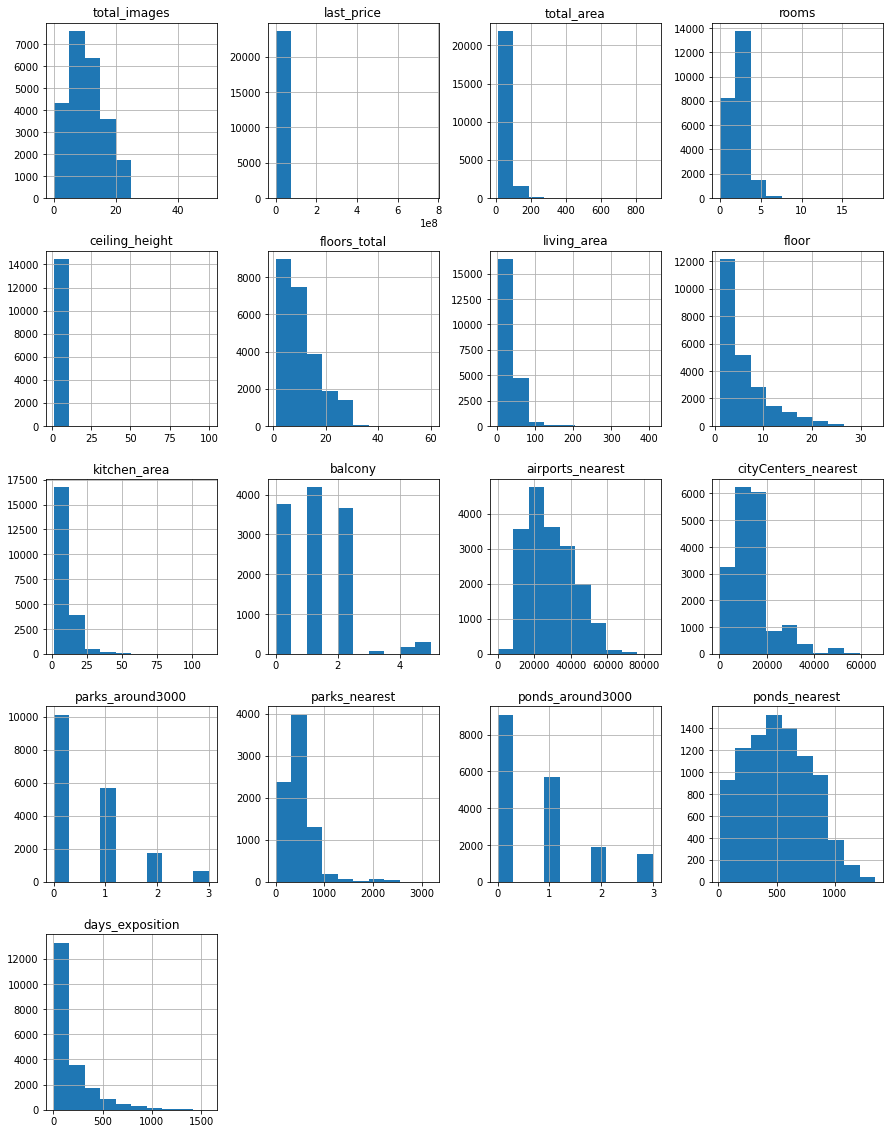

In [4]:
data.hist(figsize=(15, 20));

Из первых графиков видно, что в датафрейме около 23000 квартир стоимостью не более 100 млн. руб. *(шкала 1e8 на гистограмме last_price)*, общей площадью не более 200 м² и жил.площадью в среднем до 100 м². Также в основном приведенные квартиры имеют до 5 комнат и представлены как в многоэтажных *(до ~30 этажей)*, так и в обычных домах. Помимо основных характеристик квартир, в датафрейме указана вспомогательная информация о расположении дома и его окружении: расстояние до центра или ближайшего аэропорта, количество парков/водоёмов в пределах 3 км.

# Предобработка данных

## Работа с пропусками

Поищем пропуски в данных и посмотрим, что можно с ними сделать:

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

**Пропуски есть почти во всех столбцах, опишем работу с ними по порядку:</br>**
1. Высоту потолков `ceiling_height` могли просто не указать, пропусков достаточно много, и пытаться их заполнить — слишком смело. Вряд ли половина выборки сможет описать вторую половину корректно.
2. Другая ситуация со столбцами жилой площади `living_area` и площади кухни `kitchen_area`. Здесь пропусков достаточно много, если их удалять, можно потерять ~10% выборки. При заполнении медианным или средним значением, площадь может оказаться больше total_area, оставим пропуски как есть.
3. Касательно столбцов `airports_nearest`, `cityCenters_nearest` тоже все прозрачно — картографические данные не указали. Это достаточно второстепенные данные, да и пропусков много. Оставим как есть. Придержимся той же логики и для столбцов `parks_around3000` и `ponds_around3000`.
4. Пропуски количества балконов `balcony` правильно будет заменить на нули, вероятно, продавец не указал кол-во балконов действительно по причине его отсутствия.
5. В столбце `is_apartment` пропуски наверняка соотетствуют нулевым значениям. Заодно переведем тип данных в булев.
6. Пропуски в `locality_name` можно удалить, их всего 49. На выборку это не повлияет, а наличие информации о населенном пункте немаловажно.
7. Пропусков в `floors_total` не так много, можно оставить как есть.

Заполним пропуски в `balcony` нулями.

In [6]:
data['balcony'] = data['balcony'].fillna(0)

Проверка

In [7]:
print(data['balcony'].isna().sum())

0


**Посмотрим на столбец `is_apartment`.**

In [8]:
data['is_apartment'].describe()

count      2775
unique        2
top       False
freq       2725
Name: is_apartment, dtype: object

Заменим пропуски на False и снова запустим ячейку выше для проверки.

In [9]:
data['is_apartment'] = data['is_apartment'].fillna(False)

**Удаление пропусков в `locality_name`.**

In [10]:
data = data.dropna(subset=['locality_name'])

In [11]:
data.info() #теперь в датафрейме 23650 строк

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23650 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23650 non-null  int64  
 1   last_price            23650 non-null  float64
 2   total_area            23650 non-null  float64
 3   first_day_exposition  23650 non-null  object 
 4   rooms                 23650 non-null  int64  
 5   ceiling_height        14490 non-null  float64
 6   floors_total          23565 non-null  float64
 7   living_area           21752 non-null  float64
 8   floor                 23650 non-null  int64  
 9   is_apartment          23650 non-null  bool   
 10  studio                23650 non-null  bool   
 11  open_plan             23650 non-null  bool   
 12  kitchen_area          21381 non-null  float64
 13  balcony               23650 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

## Изменение типов данных

Поменяем тип данных в столбце `'first_day_exposition'` на **`datetime`**, нам нужно будет работать с датами. `'balcony'` и `'is_apartment'` на **`bool`**, поскольку данные там категориальные, а `'parks_around3000'`, `'ponds_around3000'` на **`int`** — они все равно принимают только целые значения. Расстояния до парков/прудов и `'days_exposition'` останутся типа **`float`**, мы там оставляли пропуски в виде `NaN`.

In [12]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%d')

In [13]:
data[['balcony', 'is_apartment']] = data[['balcony', 'is_apartment']].astype('bool')

In [14]:
data[['parks_around3000', 'ponds_around3000']] = data[['balcony', 'is_apartment']].astype('int')

Посмотрим, как теперь выглядит датафрейм. И повторим вывод `.describe()` в ячейке выше.

In [15]:
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07,3,2.70,16.0,51.0,8,False,...,25.0,False,Санкт-Петербург,18863.0,16028.0,0,482.0,0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04,1,NaN,11.0,18.6,1,False,...,11.0,True,посёлок Шушары,12817.0,18603.0,1,NaN,0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20,2,NaN,5.0,34.3,4,False,...,8.3,False,Санкт-Петербург,21741.0,13933.0,0,90.0,0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24,3,NaN,14.0,NaN,9,False,...,NaN,False,Санкт-Петербург,28098.0,6800.0,0,84.0,0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19,2,3.03,14.0,32.0,13,False,...,41.0,False,Санкт-Петербург,31856.0,8098.0,0,112.0,0,48.0,121.0


## Обработка неявных дубликатов

Необходимо заменить похожие значения в столбце с названиями `locality_name`. Посмотрим, какие населенные пункты там вообще имеются.

In [16]:
data.groupby('locality_name')['locality_name'].count().head()

locality_name
Бокситогорск     16
Волосово         36
Волхов          111
Всеволожск      398
Выборг          237
Name: locality_name, dtype: int64

In [17]:
names_recover = data['locality_name'].copy() #создадим бэкап, чтобы не перезаписывать data каждый раз

In [18]:
data['locality_name'] = names_recover.copy()

In [19]:
data['locality_name'] = data['locality_name'].str.replace('ё', 'е') #использование ё может неявно дублировать строки
dupls = ['городской поселок ','садоводческое некоммерческое товарищество ', 'садовое товарищество ', 
         'коттеджный поселок ', 'поселок городского типа ', 'поселок городского типа ', 'поселок станции ', 
         'поселок станции ', 'поселок при железнодорожной станции ', 'поселок ']
for item in dupls:
    data['locality_name'] = data['locality_name'].str.replace(item, 'поселок ') #обозначим все приведенные пункты поселками


Посмотрим, что получилось после замены. Вызвав метод `.group_by()` заодно отсортируем строки в алфавитном порядке.

In [20]:
data.groupby('locality_name')['locality_name'].count().head()

locality_name
Бокситогорск     16
Волосово         36
Волхов          111
Всеволожск      398
Выборг          237
Name: locality_name, dtype: int64

Остались только *города*, *деревни*, *поселки* и *села*. Примечательно, что названия городов могут входить в названия поселков/деревень/сел. Например, Мурино и поселок Мурино, хотя его уже давно можно считать пригородом. Чтобы устранить такие дубликаты, выделим уникальные названия городов, а затем будем искать совпадения в `locality_name`.

In [21]:
def uniq_names(row):
    if ('поселок ' not in str(row['locality_name'])) & \
       ('деревня ' not in str(row['locality_name'])) & \
       ('село'     not in str(row['locality_name'])):
        return str(row['locality_name'])
    return None

In [22]:
uniq_names = data.apply(uniq_names, axis=1).unique()

In [23]:
uniq_names #посмотрим на полученные уникальные названия

array(['Санкт-Петербург', None, 'Ломоносов', 'Сертолово', 'Петергоф',
       'Пушкин', 'Коммунар', 'Колпино', 'Гатчина', 'Выборг', 'Кронштадт',
       'Кировск', 'Павловск', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'Красное Село', 'Сясьстрой', 'Сланцы',
       'Ивангород', 'Мурино', 'Шлиссельбург', 'Никольское', 'Зеленогорск',
       'Сосновый Бор', 'Кудрово', 'Кириши', 'Луга', 'Волосово',
       'Отрадное', 'Тихвин', 'Тосно', 'Бокситогорск', 'Пикалево',
       'Подпорожье', 'Приморск', 'Новая Ладога', 'Лодейное Поле',
       'Светогорск', 'Любань', 'Каменногорск', 'Высоцк'], dtype=object)

In [24]:
def edit_names(row):
    for item in uniq_names:
        if str(item) in str(row): #ищем совпадения 
            return str(item) #и заменяем на значение из списка уникальных
    return str(row) #если нет, оставляем как есть

In [25]:
data['locality_name'] = data['locality_name'].apply(edit_names)

In [26]:
data['locality_name'].value_counts(dropna=False).head(20) #Теперь Мурино не поселок

Санкт-Петербург            15721
Мурино                       590
Кудрово                      472
поселок Шушары               440
Всеволожск                   398
Пушкин                       369
Колпино                      338
поселок Парголово            327
Гатчина                      307
Выборг                       237
Петергоф                     201
Сестрорецк                   183
Красное Село                 178
деревня Новое Девяткино      144
Сертолово                    142
Ломоносов                    133
Кириши                       125
поселок Бугры                114
Сланцы                       112
Волхов                       111
Name: locality_name, dtype: int64

In [27]:
data['locality_name'].shape #кол-во строк осталось прежним

(23650,)

## Устранение выбросов

Для поиска выбросов вновь обратимся к [гистограммам](#hist) и вызовем метод `.describe()`.

In [28]:
data.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,23650.000000,2.365000e+04,23650.000000,23650.000000,14490.000000,23565.000000,21752.000000,23650.000000,21381.000000,18116.000000,18139.000000,23650.000000,8064.000000,23650.000000,9085.000000,20470.000000
mean,9.862326,6.541127e+06,60.329069,2.070106,2.771287,10.675875,34.448356,5.893277,10.566403,28803.225878,14197.860742,0.355687,490.830729,0.002114,518.059879,180.753200
std,5.682278,1.089640e+07,35.661808,1.078620,1.261593,6.594823,22.037664,4.883317,5.901753,12637.314144,8606.830295,0.478731,342.554386,0.045932,277.841733,219.777916
min,0.000000,1.219000e+04,12.000000,0.000000,1.000000,1.000000,2.000000,1.000000,1.300000,0.000000,181.000000,0.000000,1.000000,0.000000,13.000000,1.000000
25%,6.000000,3.400000e+06,40.000000,1.000000,2.520000,5.000000,18.600000,2.000000,7.000000,18575.750000,9241.000000,0.000000,288.000000,0.000000,293.000000,45.000000
50%,9.000000,4.650000e+06,52.000000,2.000000,2.650000,9.000000,30.000000,4.000000,9.100000,26756.500000,13105.000000,0.000000,454.500000,0.000000,502.000000,95.000000
75%,14.000000,6.799000e+06,69.700000,3.000000,2.800000,16.000000,42.300000,8.000000,12.000000,37294.000000,16293.000000,1.000000,612.000000,0.000000,730.000000,231.000000
max,50.000000,7.630000e+08,900.000000,19.000000,100.000000,60.000000,409.700000,33.000000,112.000000,84869.000000,65968.000000,1.000000,3190.000000,1.000000,1344.000000,1580.000000


Начнем по порядку. Достаточно выбивающиеся значения можно наблюдать в `total_area` и `living_area`, судя по графикам, таких строк единицы.

In [29]:
data.pivot_table(index='total_area', values = 'living_area', aggfunc='mean').tail(10)

,living_area
total_area,
483.9,312.5
488.0,216.0
491.0,274.0
495.0,347.5
507.0,301.5
517.0,332.0
590.0,409.0
618.0,258.0
631.2,322.3


Можно поверить, что существуют большие дома с общей площадью в 500 м² и жилой площадью в 200-400 м², но также присутствуют строки, где общая площадь порядка 600 м², а жилая ровно 30 м². Выглядит неправдоподобно, построим диаграмму размаха.

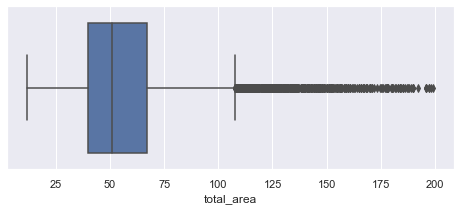

In [95]:
sns.set(rc={"figure.figsize":(8, 3)})
sns.boxplot(x='total_area', data=data);

Согласно диаграмме, все, что находится за пределами "усов", уже можно классифицировать как выброс. В данном случае квартиль Q1 = 40 м², Q3 = 69.7 м² и выбросами будут значения выше 114,25 м².

In [31]:
data.query('total_area > 114')['total_area'].count()

1250

Получается порядка 5%, немало, в целом 100 м² значение не сильно большое для домов бизнес или элитного класса. Судя по гистограмме в начале блокнота, квартир с площадью больше 200 м² совсем мало. Попробуем повысить порог и проверим.

In [32]:
data.query('total_area > 200')['total_area'].count()

227

Другое дело. И данных много не потеряем, и большие квартиры учтем, в рамках разумного.

In [33]:
data = data[data['total_area'] < 200]

In [34]:
data.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,23419.000000,2.341900e+04,23419.000000,23419.000000,14342.000000,23335.000000,21550.000000,23419.000000,21180.000000,17892.000000,17912.000000,23419.000000,7913.000000,23419.000000,8922.000000,20291.000000
mean,9.837183,6.021068e+06,58.131265,2.033691,2.764546,10.717806,33.231009,5.903454,10.380954,28831.710038,14287.268144,0.356762,492.038797,0.002050,520.055817,179.554532
std,5.667119,6.229997e+06,26.455600,0.995429,1.265166,6.603342,17.343601,4.892772,5.363177,12684.166648,8591.307136,0.479054,343.302589,0.045227,277.701788,218.369956
min,0.000000,1.219000e+04,12.000000,0.000000,1.000000,1.000000,2.000000,1.000000,1.300000,0.000000,181.000000,0.000000,1.000000,0.000000,13.000000,1.000000
25%,6.000000,3.400000e+06,40.000000,1.000000,2.510000,5.000000,18.600000,2.000000,7.000000,18503.000000,9436.000000,0.000000,288.000000,0.000000,297.000000,45.000000
50%,9.000000,4.600000e+06,51.800000,2.000000,2.650000,9.000000,30.000000,4.000000,9.000000,26822.000000,13161.000000,0.000000,456.000000,0.000000,503.000000,95.000000
75%,14.000000,6.700000e+06,68.800000,3.000000,2.800000,16.000000,42.000000,8.000000,12.000000,37365.000000,16327.500000,1.000000,613.000000,0.000000,732.000000,229.000000
max,50.000000,3.300000e+08,199.200000,11.000000,100.000000,60.000000,164.700000,33.000000,93.200000,84869.000000,65968.000000,1.000000,3190.000000,1.000000,1344.000000,1580.000000


In [35]:
data.shape

(23419, 22)

In [36]:
data_recover = data.copy()

In [37]:
data = data_recover.copy()

Из-за большого количества пропусков в `living_area` и `kitchen_area`, после среза потеряется много данных. Лучше оставить здесь данные как есть.

In [38]:
print(data.query('living_area < 10')['living_area'].count()) #всего 25 записей
print(data[data['living_area'] >= 10].shape[0]) #а потеряется 2200 строк
print(data.query('kitchen_area < 4')['kitchen_area'].count()) #29 записей
print(data[data['kitchen_area'] > 4].shape[0]) #потеряется 2100 строк

25
21525
29
21126


In [39]:
print(data['living_area'].isna().sum())
print(data['kitchen_area'].isna().sum())

1869
2239


**Посмотрим на количество комнат `rooms`.**

In [40]:
data.groupby('rooms')['rooms'].count()

rooms
0      196
1     8035
2     7924
3     5782
4     1132
5      264
6       62
7       20
8        2
11       2
Name: rooms, dtype: int64

Ноль комнат имеет смысл заменить на 1, может, подразумевали студию. Семь и более уже слишком, их удалим.

In [41]:
data[data['rooms'] < 7].shape[0] #останется 23395 строк, можно удалять.

23395

In [42]:
data = data[data['rooms'] < 7]
data.loc[data['rooms'] == 0, 'rooms'] = 1

**Теперь займемся потолками. В `ceiling_height` нашлись потолки в 100 м.**

In [43]:
data.groupby('ceiling_height')['ceiling_height'].count().head()

ceiling_height
1.00     1
1.20     1
1.75     1
2.00    11
2.20     1
Name: ceiling_height, dtype: int64

In [44]:
data['ceiling_height'].isna().sum() #9070 пропусков

9070

In [45]:
data.shape

(23395, 22)

Значения от 24 до 32 м можно поделить на 10. Скорее всего, ошиблись в типовых значениях потолков. Также удалим 100 м и построим гистограмму.

In [46]:
data = data[data['ceiling_height'] != 100]

In [47]:
rows = (data['ceiling_height'] <= 32) & (data['ceiling_height'] >= 24)
data.loc[rows,'ceiling_height'] *= 0.1

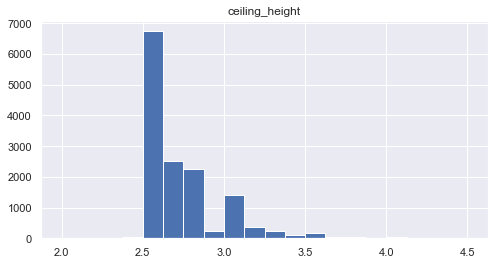

In [48]:
data.hist('ceiling_height', bins=20, range=(2, 4.5));

Оставим потолки от 2,4 до 4 метров.

In [49]:
data[(data['ceiling_height'] <= 4) & (data['ceiling_height'] >= 2.4)].shape

(14261, 22)

После предполагаемого среза потеряется большое количество данных, можно попробовать заполнить пропуски медианой, а уже затем удалить выбросы.

In [50]:
data['ceiling_height'].describe()

count    14324.000000
mean         2.723813
std          0.373818
min          1.000000
25%          2.500000
50%          2.650000
75%          2.800000
max         22.600000
Name: ceiling_height, dtype: float64

In [51]:
data['ceiling_height'] = data['ceiling_height'].fillna(data['ceiling_height'].median())

In [52]:
data[(data['ceiling_height'] <= 4) & (data['ceiling_height'] >= 2.4)].shape #теперь удалится немного строк

(23331, 22)

In [53]:
data = data[(data['ceiling_height'] <= 4) & (data['ceiling_height'] >= 2.4)]

**Посмотрим на выбросы в `last_price`.**

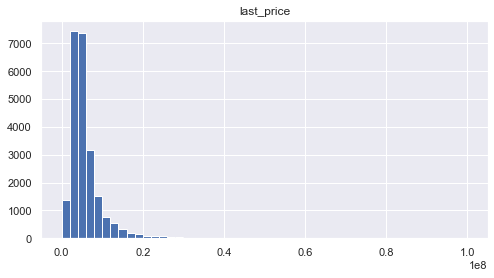

In [54]:
data.hist('last_price', bins=50, range=(0, 100000000));

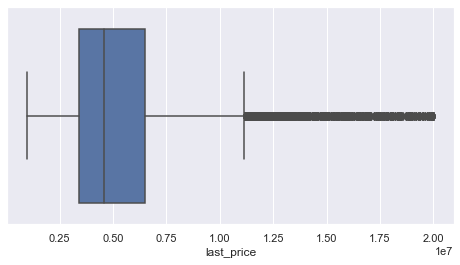

In [96]:
sns.set(rc={"figure.figsize":(8, 4)})
sns.boxplot(x='last_price', data=data);

На графиках видно много выбросов выше ~12 млн. (согласно полуторному межквартильному размаху, 11,3 млн. — предел диаграммы), а распределение походит на нормальное. Посмотрим, сколько строк выше 12 млн. и слишком малых, ниже 1 млн.

In [56]:
data[data['last_price'] > 12000000]['last_price'].count()

1672

In [57]:
data[data['last_price'] < 1000000]['last_price'].count()

224

Скорректируем верхний предел до 20 млн. и удалим.

In [58]:
data[(data['last_price'] <= 20000000) & (data['last_price'] >= 1000000)].shape

(22601, 22)

In [59]:
data = data[(data['last_price'] <= 20000000) & (data['last_price'] >= 1000000)]

**Посмотрим на распределение расстояния до центра `cityCenters_nearest`.**

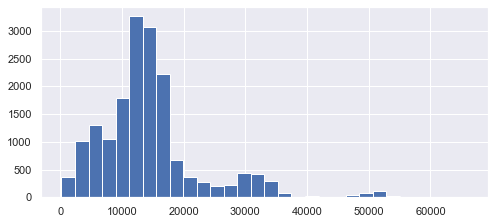

In [60]:
data['cityCenters_nearest'].hist(bins=30);

Оно похоже на нормальное, но в районе 30 км вновь возникает прирост. Возможно, ошиблись со значениями. Умножим диапазон 25000-35000 на 0,1.

In [61]:
rows = (data['cityCenters_nearest'] <= 35000) & (data['cityCenters_nearest'] >= 25000)
data.loc[rows,'cityCenters_nearest'] *= 0.1

In [62]:
data['cityCenters_nearest'].describe()

count    17351.000000
mean     12192.511602
std       7557.568761
min        208.000000
25%       7305.000000
50%      12283.000000
75%      15282.000000
max      65968.000000
Name: cityCenters_nearest, dtype: float64

In [63]:
data.shape

(22601, 22)

Аномалии и пропущенные значения устранены, можно работать с данными.

## Посчитаем и добавим в таблицу новые столбцы

In [64]:
data['metre_price'] = data['last_price'] / data['total_area'] #цена квадратного метра
data['day_publication'] = data['first_day_exposition'].dt.weekday #день недели
data['month_publication'] = data['first_day_exposition'].dt.month #месяц
data['year_publication'] = data['first_day_exposition'].dt.year #год

In [65]:
def floor_type(row): #обозначим этажи
    if row['floor'] == 1:
        return 'первый'
    elif row['floor'] == row['floors_total']:
        return 'последний'
    return 'другой'

In [66]:
data['floor_type'] = data.apply(floor_type, axis=1)

In [67]:
data['cityCenters_nearest'] = (data['cityCenters_nearest'] * 0.001).round() #перевели в км и округлили

## Проведем исследовательский анализ данных

### Изучение параметров объектов

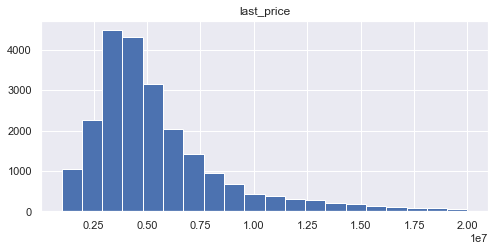

In [68]:
data.hist('last_price', bins = 20);

Цены квартир распределены нормально, среднее значение в районе 4 млн. руб.

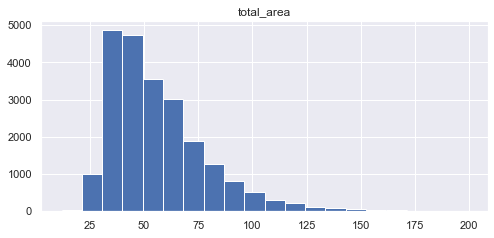

In [69]:
data.hist('total_area', bins = 20);

Общая площадь резко возрастает после отметки в 25 км.м. Больше всего квартир имеют около 40 кв.м., а с последющим увеличением площади, количество представленных квартир стремится на спад.

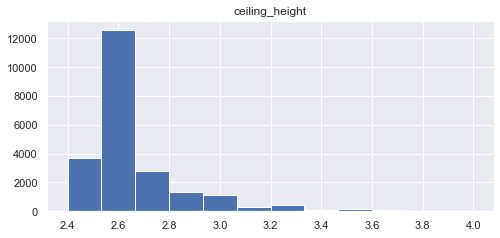

In [70]:
data.hist('ceiling_height', bins = 12);

Львиную долю составляют потолки 2,6 м, поскольку этим значением были заполнены пропуски. Максимальная высота была оставлена до 4 м.

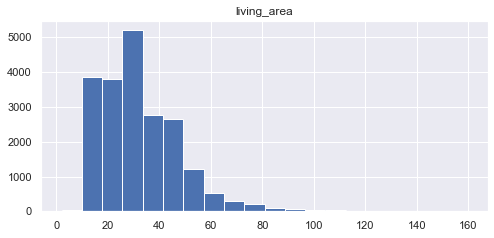

In [71]:
data.hist('living_area', bins = 20);

В целом, квартиры имеют 15-50 кв.м. жилой площади. Наибольшее количество с площадью около 30 кв.м.

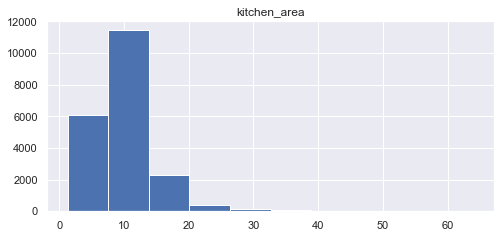

In [72]:
data.hist('kitchen_area', bins = 10);

Наиболее стандартная площадь кухни — 10-15 кв.м. В два раза меньше квартир с площадью до 10 кв.м. и в 6 раз меньше с площадью больше 15 кв.м.

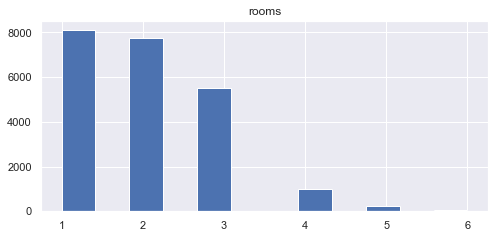

In [73]:
data.hist('rooms', bins = 12);

Больше всего объявлений однокомнатных квартир, порядка 8000, примерно столько же составляют двухкомнатные. Трехкомнатных квартир на треть меньше, а четырех- и более — меньше 1000.

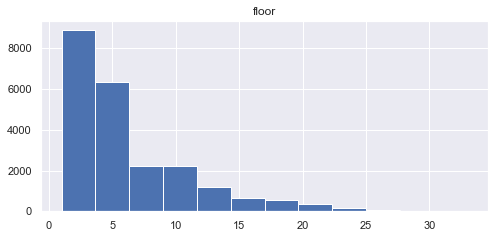

In [74]:
data.hist('floor', bins = 12);

Наибольшее число объявлений для квартир, расположенных на 5 этаже и ниже. Квартир на более высоких этажах в 3-4 раза меньше.

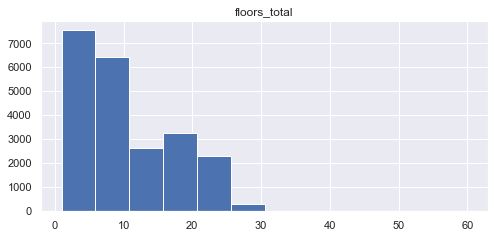

In [75]:
data.hist('floors_total', bins = 12);

Этажность домов простирается вплоть до 30, но в основном в выборке представлены пяти- и девятиэтажки. Домов с этажами более 10 в два раза меньше.

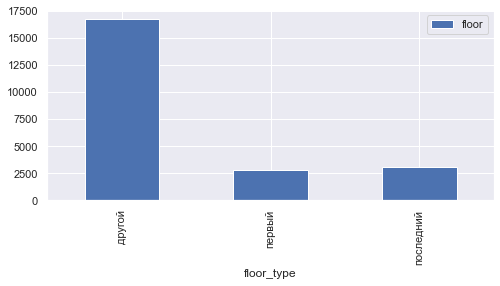

In [76]:
(data.pivot_table(index='floor_type', values='floor', aggfunc='count')
    .plot(kind='bar')
)
plt.show();

Квартир на крайних этажах примерно одинаковое количество и в сумме составляют порядка 20% всей выборки. Остальные более чем 16000 объектов расположены на других этажах.

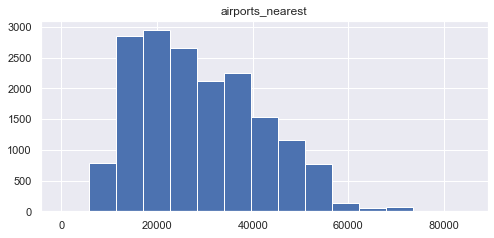

In [77]:
data.hist('airports_nearest', bins = 15);

Среднее расстояние до аэропорта составляет примерно 30 км. Можно сказать, что с увеличением дистанции, количество объектов убывает по линейному закону.

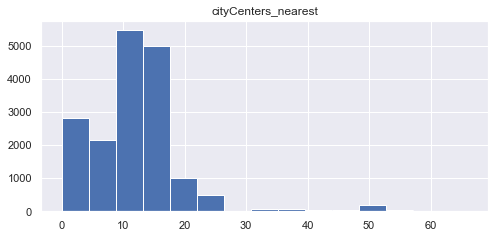

In [78]:
data.hist('cityCenters_nearest', bins = 15);

Для случайной квартиры расстояние до центра города будет составлять примерно 10-15 км. Квартир ближе 10 км к центру в 2 раза меньше. А удаленных на 20 км — меньше в 5 раз.

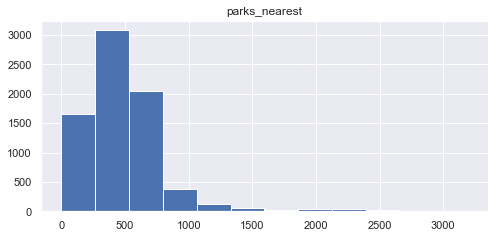

In [79]:
data.hist('parks_nearest', bins = 12);

Парк в радиусе 3 км имеется у 8000 объектов, а среднее расстояние в районе 500-700 м и, в целом, не более километра.

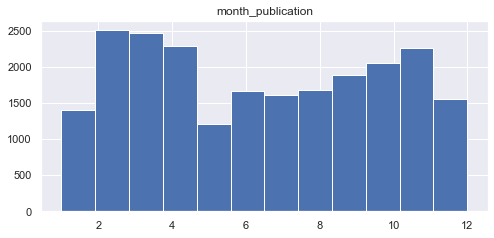

In [80]:
data.hist('month_publication', bins = 12);

Судя по графикам месяцев публикации, объекты размещаются циклично, чаще всего в феврале-апреле, в мае резкий спад, вероятно по причине большого количества выходных. Летом объем публикаций растет, но не так активно из-за отпусков. В декабре и январе количество объявлений на уровне мая по понятным причинам. Касательно дней, количество публикаций в будние дни стабильно, а в выходные ожидаемо и резко падает.

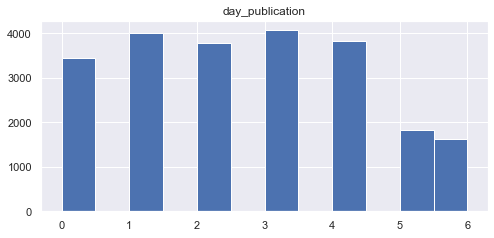

In [81]:
data.hist('day_publication', bins = 12);

Касательно дней, количество публикаций в будние дни стабильно, а в выходные ожидаемо и резко падает.

### Как быстро продавались квартиры

Чтобы попробовать сформулировать выводы, построим гистограмму по `days_exposition` и обратимся к методу `.describe()`.

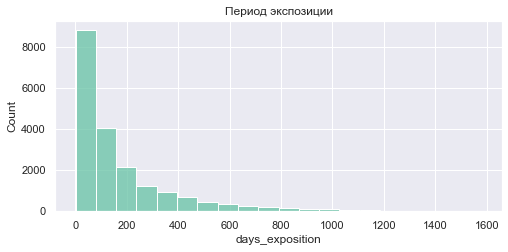

In [82]:
with sns.color_palette('Set2'):
    sns.histplot(data=data, x='days_exposition', bins=20)
plt.title('Период экспозиции')
plt.show();

In [83]:
data['days_exposition'].describe()

count    19687.000000
mean       177.736882
std        216.598455
min          1.000000
25%         44.000000
50%         93.000000
75%        226.000000
max       1580.000000
Name: days_exposition, dtype: float64

В среднем квартиры продаются за 177 дней, а половину всех квартир продали за 93 дня. Значения до первого квартиля Q1 можно принять за быструю продажу — 25% всех квартир продали за 44 дня. А **необычно долгой** продажей можно принять случаи, лежащие в пределе одного стандартного отклонения от среднего — 394 дня. В этот промежуток попадает примерно 13,6% + 2,1% = 15,7% выборки, согласно эмпирическому правилу 68-95-99,7. Это как раз будет соответствовать примерно удвоенному среднему, такой предел оптимален, поскольку значение квартиля Q3 весьма мало, чтобы назвать продажи **необычно** долгими.

### Какие факторы больше всего влияют на полную стоимость объекта

Построим гистограммы для категории этажа, дня, месяца и года продажи.

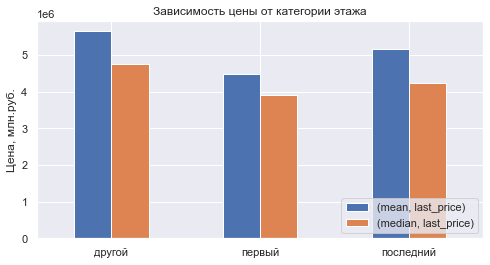

In [84]:
(data.pivot_table(index='floor_type', values='last_price', aggfunc=['mean', 'median'])
     .plot.bar(rot=0, xlabel='', ylabel='Цена, млн.руб.', title='Зависимость цены от категории этажа', figsize=(8, 4))
)
plt.legend(loc='lower right')
plt.show();

На первом этаже располгаются самые дешевые квартиры, средняя стоимость 4,5 млн. руб, а половина всех — дешевле 4 млн. руб. Самые дорогие располагаются на остальных этажах, кроме последнего, средняя стоимость на 1 млн. больше, а медиана выше на 0,5 млн. В промежутке находятся квартиры последнего этажа, в среднем они стоят 5 млн.руб, а медианное значение составляет примерно 4 млн. *Можно сказать, если квартира находится не на крайних этажах, то цена такого объекта в среднем будет наибольшая.*

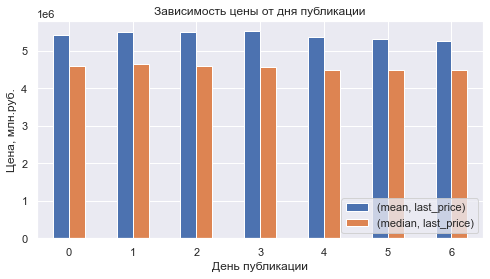

In [85]:
(data.pivot_table(index='day_publication', values='last_price', aggfunc=['mean', 'median'])
     .plot.bar(rot=0, xlabel='День публикации', ylabel='Цена, млн.руб.', title='Зависимость цены от дня публикации', figsize=(8, 4))
)
plt.legend(loc='lower right')
plt.show()

*Зависимость цены от дня публикации не прослеживается, для каждого дня значения среднего и медианы примерно одинаковые.*

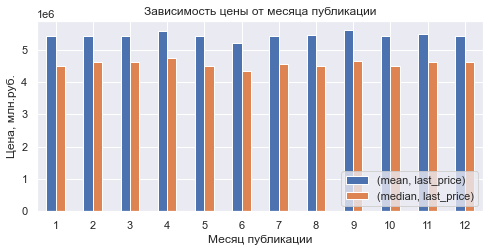

In [86]:
(data.pivot_table(index='month_publication', values='last_price', aggfunc=['mean', 'median'])
     .plot.bar(rot=0, xlabel='Месяц публикации', ylabel='Цена, млн.руб.', title='Зависимость цены от месяца публикации', 
               figsize=(8, 3.5))
)
plt.legend(loc='lower right')
plt.show()

Зависимость цены от месяца публикации тоже слабо прослеживается. Средняя цена колеблется в районе ~5,2-5,5 млн.руб. Медианное значение имеет такие же колебания, только вокруг 4,5 млн. руб.

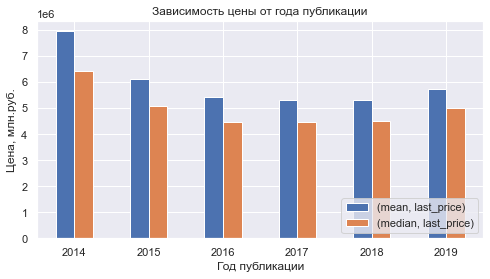

In [87]:
(data.pivot_table(index='year_publication', values='last_price', aggfunc=['mean', 'median'])
     .plot.bar(rot=0, xlabel='Год публикации', ylabel='Цена, млн.руб.', title='Зависимость цены от года публикации',
              figsize=(8, 4))
)
plt.legend(loc='lower right')
plt.show()

Зависимость от года публикации присутствует. В 2014 году наблюдается наибольшая цена, вероятно, связано с изменением курса рубля в 2 раза в том году. До 2016 цены корректировались и остались на значении ~5,3 млн.руб для среднего и 4,5 млн.руб для медианы. В 2019 недвижимость снова подорожала на полмиллиона.

### Подсчет средней цены одного квадратного метра

Требуется посчитать цену квадратного метра в 10 населенных пунктах с наибольшим числом объявлений, список этих пунктов получим с помощью `value_counts()`. Стоимость одного квадратного метра раннее рассчитывалась в столбце `metre_price`.

In [88]:
locality = data['locality_name'].value_counts().head(10).index

In [89]:
locality

Index(['Санкт-Петербург', 'Мурино', 'Кудрово', 'поселок Шушары', 'Всеволожск',
       'Пушкин', 'Колпино', 'поселок Парголово', 'Гатчина', 'Выборг'],
      dtype='object')

In [90]:
(data.query('locality_name in @locality')
     .pivot_table(index='locality_name', values='metre_price')
     .sort_values(by='metre_price', ascending=False)
)    

,metre_price
locality_name,
Санкт-Петербург,108721.385183
Пушкин,101794.625455
Кудрово,95326.179139
поселок Парголово,90332.263023
Мурино,86087.512050
поселок Шушары,78677.364217
Колпино,75333.295801
Гатчина,68935.194838
Всеволожск,67284.660180


Дороже всего недвижимость, разумеется, в Санкт-Петербурге — средняя стоимость 1 м² составляет 108,7 тыс. руб. В Выборге квадратный метр стоит дешевле всего — в среднем 58,7 тыс. руб.

### Изменение стоимости объекта в Санкт-Петербурге в зависимости удаленности от центра

Посмотрим на графике зависимость стоимости объекта в петербурге от расстояния до центра города. Отберем данные по Петербургу, сгруппируем по расстоянию до центра `cityCenters_nearest` и выберем столбец `last_price`.

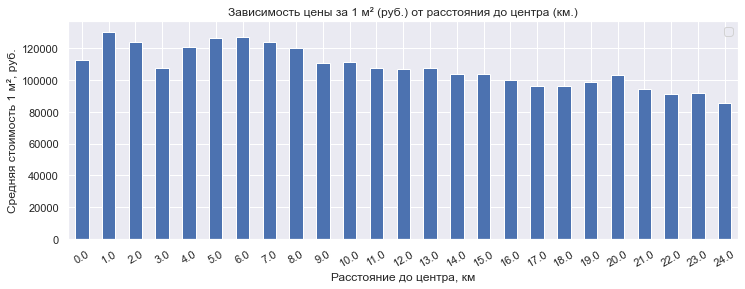

In [91]:
(data.query('locality_name == "Санкт-Петербург" & cityCenters_nearest < 25')
     .pivot_table(index='cityCenters_nearest', values='metre_price')
     .plot(kind='bar', rot=30, ylabel='Средняя стоимость 1 м², руб.', xlabel='Расстояние до центра, км', figsize=(12,4))
)
plt.legend('')
plt.title('Зависимость цены за 1 м² (руб.) от расстояния до центра (км.)')
plt.show()

На графике видно, что наиболее удаленные объекты имеют цену в районе ~85 тыс.руб./м². Зависимость на графике можно грубо аппроксимировать, но лучше попробуем вычислить среднюю разницу при изменении удаленности на 1 км.

Сохраним сводную таблицу для дальнейших вычислений.

In [92]:
pivot_table = (data.query('locality_name == "Санкт-Петербург" & cityCenters_nearest < 25')
                   .pivot_table(index='cityCenters_nearest', values='metre_price')
              )
pivot_table.tail()

,metre_price
cityCenters_nearest,
20.0,103056.539879
21.0,94469.584582
22.0,91330.425050
23.0,92063.679612
24.0,85736.904595


Далее получим разницу стоимости квадратного метра с каждым километром удаленности от центра. На графике видно, что в первые 4 километра зависимость имеет несколько хаотичный характер. В качестве среднего прироста примем среднее значение.

In [93]:
(pivot_table['metre_price'].shift(1) - pivot_table['metre_price']).shift(0).head(7)

cityCenters_nearest
0.0             NaN
1.0   -17837.490148
2.0     6537.571769
3.0    16157.320550
4.0   -13161.977630
5.0    -5278.133555
6.0    -1054.444705
Name: metre_price, dtype: float64

In [94]:
(pivot_table['metre_price'].shift(1) - pivot_table['metre_price']).shift(0).describe()

count       24.000000
mean      1123.722713
std       6990.964517
min     -17837.490148
25%       -955.560981
50%       1698.785651
75%       3924.688595
max      16157.320550
Name: metre_price, dtype: float64

Получается, средняя цена каждого километра составляет 1698 руб. за 1 м². Попробуем спрогнозировать цену, перейдем из точки в 24 км и стоимостью 85 тыс. руб. в точки 10 км и 5 км соответственно. <br> 
Цена для 10 км будет: 85000 + 1698 * (24 - 10) = 108772 руб. <br> 
Цена для 5 км: 85000 + 1698 * (24 - 5) = 117262 руб. <br>
*Эти результаты примерно соответствуют значениям на графиках.*

# Общий вывод

В текущей работе было проведено исследование данных из сервиса Яндекс Недвижимость, архив содержал информацию об объявлениях за неколько лет о продаже квартир в Санкт-Петербурге и соседних населенных пунктах. В исследовании изучались следующие параметры объектов недвижимости: <br>
  - общая площадь;
  - жилая площадь;
  - площадь кухни;
  - цена объекта;
  - количество комнат;
  - высота потолков;
  - этаж квартиры;
  - тип этажа квартиры («первый», «последний», «другой»);
  - общее количество этажей в доме;
  - расстояние до центра города в метрах;
  - расстояние до ближайшего аэропорта;
  - расстояние до ближайшего парка;
  - день и месяц публикации объявления.

1. Львиную долю объектов в выборке составляют квартиры из Санкт-Петербурга и Мурино — 69%. В большинстве представлены квартиры с площадью до 100 м², в среднем около 50 м². Жилая площадь квартир составляет около половины от общей: 25-50 м², а кухни в среднем представлены порядка 10 м². Цены на недвижимость распределены нормально, среднее значение в районе 4 млн.руб, на этапе предобработки были удалены объекты дороже 20 млн. руб. и дешевле 1 млн. руб. Высоты потолков разбросаны достаточно хаотично, но львиную долю составляют потолки 2,4-2,6 м, максимальная высота 3,2 м. Большинство объектов имеют до двух комнат, квартир с тремя комнатами примерно на треть меньше. Этажность домов простирается вплоть до 30, но в основном представлены пяти- и девятиэтажки. Домов с этажами более 10 в два раза меньше.
2. Изучался вопрос о том, насколько быстро продаваются квартиры. В среднем объекты продаются за 177 дней, а половину всех квартир продали за 93 дня. Согласно значению первого квартиля Q1 — 25% всех квартир продали за 44 дня — **быстрые продажи**. А **необычно долгой** продаже соответствуют случаи, лежащие в пределе одного стандартного отклонения от среднего — 394 дня.
3. Проводилось исследование и отбор факторов, наиболее влияющих на стоимость объекта. Обнаружено, что на первом этаже располагаются самые дешевые квартиры, средняя стоимость 4,5 млн. руб, а половина всех — дешевле 4 млн. руб. Самые дорогие располагаются на остальных этажах, кроме последнего, средняя стоимость на 1 млн. больше, а медиана выше на 0,5 млн. В промежутке находятся квартиры последнего этажа, в среднем они стоят 5 млн.руб, а медианное значение составляет примерно 4 млн. *Можно сказать, если квартира находится не на крайних этажах, то цена такого объекта в среднем будет наибольшая.* Зависимость от дня и месяца публикации не замечена, зато зависимость от года публикации присутствует. В 2014 году наблюдается наибольшая цена, вероятно, связано с изменением курса рубля в 2 раза в том году. До 2016 цены корректировались и остались на значении ~5,3 млн.руб для среднего и 4,5 млн.руб для медианы. В 2019 недвижимость снова подорожала на полмиллиона.
4. Была посчитана средняя стоимость одного квадратного метра в 10 населенных пунктах с наибольшим числом объявлений. Самая дорогая недвижимость, конечно, в Санкт-Петербурге — средняя цена 108,7 тыс.руб./м². В Выборге недвижимость стоит дешевле всего — в среднем 58,7 тыс.руб./м².
5. Также был найден прирост стоимости квадратного метра по мере удаленности от центра Санкт-Петербурга на 1 км. Средняя цена каждого километра составляет 1698 руб. за 1 м². Наиболее удаленные объекты имеют цену в районе ~83 тыс.руб./м² — относительно этой точки прогнозировались цены для новой произвольной удаленности. Полученные результаты соответствуют показаниям на графике.